In [1]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from tqdm.notebook import trange, tqdm
from pypfopt import HRPOpt
from pypfopt import expected_returns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the tickers and date range 
tickers = ["CGL.TO",  # iShares Gold Bullion ETF (CAD-Hedged)
           "HBD.TO",  # BetaPro Gold Bullion -2x Daily Bear ETF
           "VFV.TO",  # Vanguard S&P 500 Index ETF
           "HIU.TO",  # BetaPro S&P 500 Daily Inverse ETF
           "XGB.TO",  # iShares Core Canadian Government Bond Index ETF
           "XEQT.TO", # iShares Core Equity ETF Portfolio
           "ENB.TO",  # Enbridge Inc.
           "RY.TO",   # Royal Bank of Canada
           "WMT",     # Walmart Inc.
           "AAPL",    # Apple Inc.
           "V",       # Visa Inc.
           "MSFT",    # Microsoft Corporation
           "BRK-B",   # Berkshire Hathaway Inc.
           "TSLA",    # Tesla Inc.
           "NVDA",    # NVIDIA Corporation
           "AMD",     # Advanced Micro Devices Inc.
           "BLK",     # BlackRock Inc.
           "JPM",     # JPMorgan Chase & Co.
           ]  

sector_mapper = {
    "CGL.TO": "Commodities",
    "HBD.TO": "Commodities",
    "VFV.TO": "Equity Index",
    "HIU.TO": "Equity Index",
    "XGB.TO": "Fixed Income",
    "XEQT.TO": "Multi-Asset",
    "ENB.TO": "Energy",
    "RY.TO": "Financials",
    "WMT": "Consumer Staples",
    "AAPL": "Technology",
    "V": "Financials",
    "MSFT": "Technology",
    "BRK-B": "Financials",
    "TSLA": "Risky",
    "NVDA": "Risky",
    "AMD": "Risky",
    "BLK": "Financials",
    "JPM": "Financials"
}

tickers_CAD = ["CGL.TO",  # iShares Gold Bullion ETF (CAD-Hedged)
               "HBD.TO",  # BetaPro Gold Bullion -2x Daily Bear ETF
               "VFV.TO",  # Vanguard S&P 500 Index ETF
               "HIU.TO",  # BetaPro S&P 500 Daily Inverse ETF
               "XGB.TO",  # iShares Core Canadian Government Bond Index ETF
               "XEQT.TO", # iShares Core Equity ETF Portfolio
               "ENB.TO",  # Enbridge Inc.
               "RY.TO",   # Royal Bank of Canada
               "WMT.NE",  # Walmart Inc.
               "APLY.NE", # Apple Inc.
               "VISA.NE", # Visa Inc.
               "MSFT.NE", # Microsoft Corporation
               "BRK.NE",  # Berkshire Hathaway Inc.
               "TSLA.NE", # Tesla Inc.
               "NVDA.NE", # NVIDIA Corporation
               "AMD.NE",  # Advanced Micro Devices Inc.
               "BLK.NE",  # BlackRock Inc.
               "JPM.NE",  # JPMorgan Chase & Co.
]  

sector_mapper_CAD = {
    "CGL.TO": "Commodities",
    "HBD.TO": "Commodities",
    "VFV.TO": "Equity Index",
    "HIU.TO": "Equity Index",
    "XGB.TO": "Fixed Income",
    "XEQT.TO": "Multi-Asset",
    "ENB.TO": "Energy",
    "RY.TO": "Financials",
    "WMT.NE": "Consumer Staples",
    "APLY.NE": "Technology",
    "VISA.NE": "Financials",
    "MSFT.NE": "Technology",
    "BRK.NE": "Financials",
    "TSLA.NE": "Risky",
    "NVDA.NE": "Risky",
    "AMD.NE": "Risky",
    "BLK.NE": "Financials",
    "JPM.NE": "Financials"
}

# "Equity Index": 0.25,
# "Commodities": 0.10,
# "Multi-Asset": 0.25,

sector_lower = {
    "Equity Index": 0.25,
    "Multi-Asset": 0.25,
}  

sector_upper = {
    "Risky": 0.40, 
}

start_date = "2016-01-05"
start_date_CAD = "2024-01-05"
# Use the current date as the end date
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
# Fetch data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)
data_CAD = yf.download(tickers_CAD, start=start_date_CAD, end=end_date)
# Extract the 'Close' prices
prices = data['Close']
prices_CAD = data_CAD['Close']

# Add all missing dates
all_dates = pd.date_range(start_date, end_date)
prices = prices.reindex(pd.date_range(start_date, end_date))
prices_CAD = prices_CAD.reindex(pd.date_range(start_date_CAD, end_date))

# Fill NaN value with previous date value
prices = prices.fillna(method='ffill')
prices_CAD = prices_CAD.fillna(method='ffill')

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed


In [3]:
prices

Ticker,AAPL,AMD,BLK,BRK-B,CGL.TO,ENB.TO,HBD.TO,HIU.TO,JPM,MSFT,NVDA,RY.TO,TSLA,V,VFV.TO,WMT,XEQT.TO,XGB.TO
2016-01-05,25.677500,2.750000,333.959991,131.250000,9.500000,46.000000,44.820000,40.720001,63.730000,55.049999,0.822250,72.820000,14.895333,76.269997,50.040001,20.973333,NaN,22.090000
2016-01-06,25.174999,2.510000,330.160004,131.330002,9.620000,44.580002,43.740002,41.099998,62.810001,54.049999,0.788250,71.570000,14.602667,75.269997,49.709999,21.183332,NaN,22.180000
2016-01-07,24.112499,2.280000,315.730011,129.479996,9.750000,43.700001,42.880001,41.939999,60.270000,52.169998,0.757000,70.250000,14.376667,73.790001,48.630001,21.676666,NaN,22.190001
2016-01-08,24.240000,2.140000,307.779999,128.330002,9.750000,44.889999,43.099998,42.480000,58.919998,52.330002,0.740750,70.070000,14.066667,72.879997,48.200001,21.180000,NaN,22.180000
2016-01-09,24.240000,2.140000,307.779999,128.330002,9.750000,44.889999,43.099998,42.480000,58.919998,52.330002,0.740750,70.070000,14.066667,72.879997,48.200001,21.180000,NaN,22.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,216.240005,134.270004,856.210022,431.670013,19.299999,53.360001,7.630000,11.960000,205.800003,406.019989,104.750000,149.839996,200.000000,259.760010,130.220001,67.949997,30.530001,19.459999
2024-08-10,216.240005,134.270004,856.210022,431.670013,19.299999,53.360001,7.630000,11.960000,205.800003,406.019989,104.750000,149.839996,200.000000,259.760010,130.220001,67.949997,30.530001,19.459999
2024-08-11,216.240005,134.270004,856.210022,431.670013,19.299999,53.360001,7.630000,11.960000,205.800003,406.019989,104.750000,149.839996,200.000000,259.760010,130.220001,67.949997,30.530001,19.459999
2024-08-12,217.529999,136.770004,838.270020,430.390015,19.629999,53.680000,7.630000,11.990000,206.190002,406.809998,109.019997,148.759995,197.490005,259.890015,130.350006,68.699997,30.549999,19.520000


In [4]:
# This amount is in USD and needs to be large
initial_investment_amount = 1000000
investment_starting_date = "2023-01-01"

# Get a dataframe of portfolio value of only investing in S&P500 (XUS.TO)
sp500 = prices['VFV.TO']
sp500 = sp500[sp500.index >= investment_starting_date]
sp500 = sp500 / sp500.iloc[0] * initial_investment_amount

In [5]:
def get_optimal_allocation(date, prices, total_portfolio_value, if_hrp=False, if_min_volatility=False, verbose=False):
    """
    Calculate the optimal allocation based on the given parameters.
    
    :param date: Date to calculate the optimal allocation
    :param prices: DataFrame of historical prices
    :param total_portfolio_value: Current total portfolio value
    :param if_hrp: 
    :param if_min_volatility: 
    :return: Dictionary of allocations and leftover cash
    """
    # Ensure the index is in the correct format
    prices.index = pd.to_datetime(prices.index)

    # Filter the prices based on the date range
    prices = prices.loc[:date]

    if if_hrp:
        mu = expected_returns.returns_from_prices(prices)

        hrp = HRPOpt(mu)
        
        # Add sector constraints
        hrp.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

        hrp.optimize()

        cleaned_weights = hrp.clean_weights()

        # Get portfolio performance metrics
        expected_annual_return, annual_volatility, sharpe_ratio = hrp.portfolio_performance(verbose=verbose)
    else:
        # Calculate expected returns and sample covariance matrix
        # mu = ema_historical_return(prices, frequency=252)
        mu = expected_returns.mean_historical_return(prices)
        
        S = CovarianceShrinkage(prices).ledoit_wolf()

        # Optimize the portfolio
        ef = EfficientFrontier(mu, S)

        # Add L2 regularization to the optimization problem
        ef.add_objective(objective_functions.L2_reg, gamma=0.1)
        
        # Add sector constraints
        ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
        
        if if_min_volatility:
            weights = ef.min_volatility()  # Uncomment this line if you prefer min volatility
        else:
            weights = ef.max_sharpe()
        

        # Get the discrete allocation of each asset
        cleaned_weights = ef.clean_weights()

        # Get portfolio performance metrics
        expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(verbose=verbose)

    # Get the latest prices
    latest_prices = get_latest_prices(prices)

    # Calculate the discrete allocation
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=total_portfolio_value)
    allocation, leftover = da.greedy_portfolio()

    # Fill the tickers that are not in the allocation with 0
    for ticker in tickers:
        if ticker not in allocation:
            allocation[ticker] = 0

    return {
        'allocation': allocation,
        'leftover': leftover,
        'weights': cleaned_weights,
        'expected_annual_return': expected_annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
    }


In [6]:
# Create a MVO dataframe with current portfolio value, all elements from the tickers, and left over cash columns
date_range = pd.date_range(investment_starting_date, end_date)
mvo = pd.DataFrame(index=date_range, columns=['Portfolio Value', 'Leftover Cash', 'isError'] + tickers)

# Initialize the portfolio
portfolio_value = initial_investment_amount
previous_allocation = pd.Series(0, index=tickers)
previous_leftover_cash = initial_investment_amount

In [7]:
# Iterate from the investment_starting_date to the end_date
for date in tqdm(date_range):
    # If the date is not a trading day, skip it
    if date not in prices.index:
        continue
    
    # Calculate the current portfolio value
    if date == pd.to_datetime(investment_starting_date):
        portfolio_value = initial_investment_amount
    else:
        price_at_date = prices.loc[date]
        portfolio_value = (price_at_date * previous_allocation).sum() + previous_leftover_cash
    
    # re-balance every Wednesday
    if date.weekday() == 2:
        try:
            # Get the optimal allocation
            allocation = get_optimal_allocation(date, prices, portfolio_value, if_hrp=False, if_min_volatility=False)
            mvo.loc[date, 'isError'] = False
        except Exception as e:
            # Use the same allocation as the previous day if an error occurs
            allocation = {
                'allocation': previous_allocation,
                'leftover': previous_leftover_cash
            }
            mvo.loc[date, 'isError'] = True
            print(e)
    else:
        # Use the same allocation as the previous day if it is not Wednesday
        mvo.loc[date, 'isError'] = False
        allocation = {
            'allocation': previous_allocation,
            'leftover': previous_leftover_cash
        }
    
    # Update the DataFrame
    mvo.loc[date, 'Portfolio Value'] = portfolio_value
    mvo.loc[date, tickers] = [allocation['allocation'].get(ticker, 0) for ticker in tickers]
    mvo.loc[date, 'Leftover Cash'] = allocation['leftover']
    
    # Update previous allocation and leftover cash for the next iteration
    # Convert the previous allocation to a Series to match the tickers
    previous_allocation = pd.Series(allocation['allocation'])
    previous_leftover_cash = allocation['leftover']
    

  0%|          | 0/591 [00:00<?, ?it/s]

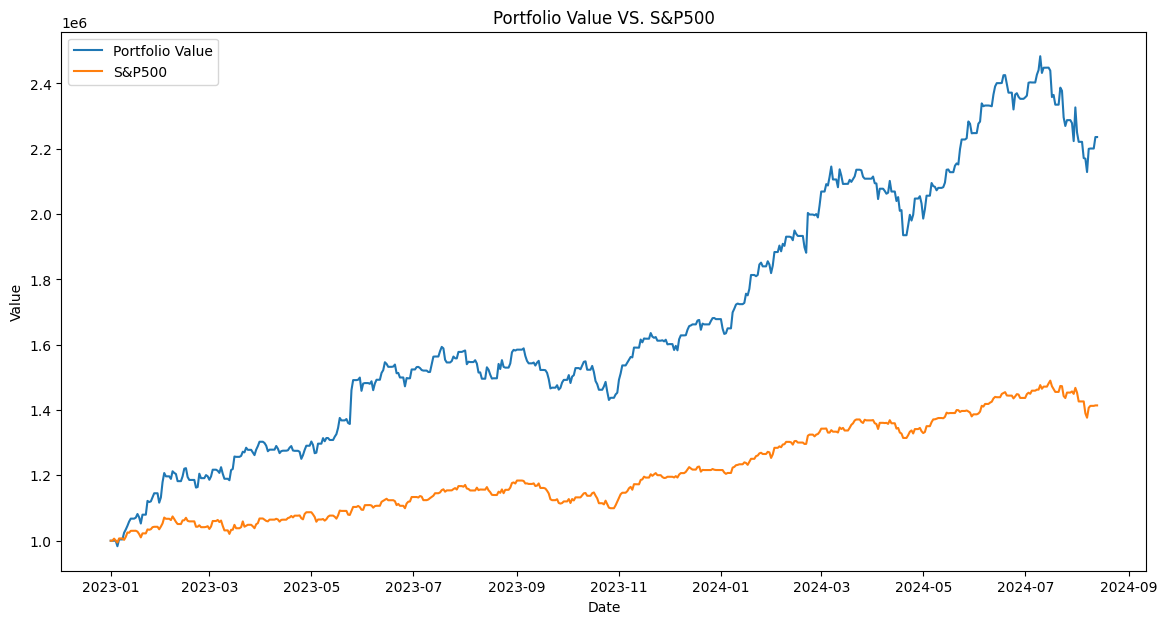

In [8]:
# Plot the portfolio value VS. S&P500
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(mvo['Portfolio Value'], label='Portfolio Value')
plt.plot(sp500, label='S&P500')
plt.title('Portfolio Value VS. S&P500')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()


In [9]:
mvo

,Portfolio Value,Leftover Cash,isError,CGL.TO,HBD.TO,VFV.TO,HIU.TO,XGB.TO,XEQT.TO,ENB.TO,...,WMT,AAPL,V,MSFT,BRK-B,TSLA,NVDA,AMD,BLK,JPM
2023-01-01,1000000,1000000,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-02,1000000.0,1000000,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-03,1000000.0,1000000,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-04,1000000.0,14.994317,False,0,0,2220,2965,0,10279,0,...,0,600,0,106,0,89,13430,2965,0,0
2023-01-05,983154.144617,14.994317,False,0,0,2220,2965,0,10279,0,...,0,600,0,106,0,89,13430,2965,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,2200654.33495,7.422705,False,0,0,2959,12809,0,17839,0,...,462,602,0,140,0,0,6922,1296,0,0
2024-08-10,2200654.33495,7.422705,False,0,0,2959,12809,0,17839,0,...,462,602,0,140,0,0,6922,1296,0,0
2024-08-11,2200654.33495,7.422705,False,0,0,2959,12809,0,17839,0,...,462,602,0,140,0,0,6922,1296,0,0
2024-08-12,2235810.634037,7.422705,False,0,0,2959,12809,0,17839,0,...,462,602,0,140,0,0,6922,1296,0,0


In [10]:
# Get the order dict for the last date by re-running the get_optimal_allocation function
current_allocation = get_optimal_allocation(end_date, prices, total_portfolio_value=3024.97, if_hrp=False, if_min_volatility=False, verbose=True)

Expected annual return: 22.3%
Annual volatility: 19.5%
Sharpe Ratio: 1.04


In [11]:
current_allocation

{'allocation': {'NVDA': 9,
  'XEQT.TO': 24,
  'VFV.TO': 4,
  'AMD': 2,
  'HIU.TO': 19,
  'AAPL': 1,
  'WMT': 1,
  'CGL.TO': 0,
  'HBD.TO': 0,
  'XGB.TO': 0,
  'ENB.TO': 0,
  'RY.TO': 0,
  'V': 0,
  'MSFT': 0,
  'BRK-B': 0,
  'TSLA': 0,
  'BLK': 0,
  'JPM': 0},
 'leftover': 1.610024185180464,
 'weights': OrderedDict([('AAPL', 0.05943),
              ('AMD', 0.077),
              ('BLK', 0.0),
              ('BRK-B', 0.0),
              ('CGL.TO', 0.0),
              ('ENB.TO', 0.0),
              ('HBD.TO', 0.0),
              ('HIU.TO', 0.07458),
              ('JPM', 0.0),
              ('MSFT', 0.0235),
              ('NVDA', 0.323),
              ('RY.TO', 0.0),
              ('TSLA', 0.0),
              ('V', 0.0),
              ('VFV.TO', 0.17542),
              ('WMT', 0.01707),
              ('XEQT.TO', 0.25),
              ('XGB.TO', 0.0)]),
 'expected_annual_return': 0.2225021176812859,
 'annual_volatility': 0.19489021587223687,
 'sharpe_ratio': 1.0390573830244978}

In [12]:
from collections import OrderedDict

# Your original orderDict
orderDict = current_allocation['weights']

# Create a mapping from tickers to tickers_CAD
ticker_mapping = dict(zip(tickers, tickers_CAD))

# Create a new OrderedDict with updated tickers
new_orderDict = OrderedDict()

for ticker, value in orderDict.items():
    if ticker in ticker_mapping:
        new_ticker = ticker_mapping[ticker]
        new_orderDict[new_ticker] = value
    else:
        new_orderDict[ticker] = value

# Print the new orderDict
new_orderDict

OrderedDict([('APLY.NE', 0.05943),
             ('AMD.NE', 0.077),
             ('BLK.NE', 0.0),
             ('BRK.NE', 0.0),
             ('CGL.TO', 0.0),
             ('ENB.TO', 0.0),
             ('HBD.TO', 0.0),
             ('HIU.TO', 0.07458),
             ('JPM.NE', 0.0),
             ('MSFT.NE', 0.0235),
             ('NVDA.NE', 0.323),
             ('RY.TO', 0.0),
             ('TSLA.NE', 0.0),
             ('VISA.NE', 0.0),
             ('VFV.TO', 0.17542),
             ('WMT.NE', 0.01707),
             ('XEQT.TO', 0.25),
             ('XGB.TO', 0.0)])

In [17]:
# Get the latest prices
latest_prices_CAD = get_latest_prices(prices_CAD)

# Calculate the discrete allocation
# allocation, leftover = DiscreteAllocation(new_orderDict, latest_prices, total_portfolio_value=3024.97).greedy_portfolio(reinvest=False, verbose=True)
allocation, leftover = DiscreteAllocation(new_orderDict, latest_prices_CAD, total_portfolio_value=3024.97).lp_portfolio()

Using Max's solver.


In [24]:
# # print all the ticker name and the price in the latest_prices_CAD
# for ticker, price in latest_prices_CAD.items():
#     print(f"{ticker}: {price}")

AMD.NE: 26.100000381469727
APLY.NE: 28.790000915527344
BLK.NE: 22.329999923706055
BRK.NE: 32.619998931884766
CGL.TO: 19.6299991607666
ENB.TO: 53.68000030517578
HBD.TO: 7.630000114440918
HIU.TO: 11.989999771118164
JPM.NE: 27.540000915527344
MSFT.NE: 29.899999618530273
NVDA.NE: 25.719999313354492
RY.TO: 148.75999450683594
TSLA.NE: 18.1200008392334
VFV.TO: 130.35000610351562
VISA.NE: 24.809999465942383
WMT.NE: 30.049999237060547
XEQT.TO: 30.549999237060547
XGB.TO: 19.520000457763672


In [18]:
allocation, leftover

({'APLY.NE': 7,
  'AMD.NE': 8,
  'HIU.TO': 19,
  'MSFT.NE': 2,
  'NVDA.NE': 38,
  'VFV.TO': 21,
  'WMT.NE': 2,
  'XEQT.TO': 25},
 2.120051098677777)

In [19]:
# Calculate the total value of the portfolio
total_value = sum([allocation[ticker] * latest_prices[ticker] for ticker in allocation]) + leftover

In [20]:
total_value

5238.620136929367